## Run Thin Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-2-Questions/blob/main/HW1_Notebook.ipynb)  
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-1-Questions/blob/main/HW1_Notebook.ipynb)

## HW2: Value Based Methods (DQN vs DDQN)

Name:

Student ID:

In this notebook we learn how to use PyTorch to train a Deep Q-Learning (DQN) agent on the [Cart-Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) task from [Gymnasium](https://gymnasium.farama.org/). The goal is to develope a hands on for coding RL Algorithms from scratch and create mindset to analyze them.

# Setup

We must first install the required packages. if you run this Notebook on Colab, There Shouldn't be any challenge for you, but if you try to run it on your local system there might be a little challenge in terms of installing dependencies.

In [1]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d]

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,609 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,313 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,612 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchp

Next we must import the following libraries.

In [2]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Here are some helper functions which will allow you to plot the training process and see the results by visualizing the gym environment.

In [3]:
# @title helper functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards,i,show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title(f'Training the Agent number {i}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_smooth(DDQN_mean_rewards,DDQN_min_rewards,DDQN_max_rewards,DQN_mean_rewards,DQN_min_rewards,DQN_max_rewards):
      plt.figure(figsize=(12,7))

      # Plot DDQN
      DDQN, = plt.plot(range(len(DDQN_mean_rewards)), DDQN_mean_rewards, color='blue', label='DDQN')
      plt.fill_between(range(len(DDQN_min_rewards)), DDQN_min_rewards, DDQN_max_rewards, color='blue', alpha=0.2)

      # Plot DQN
      DQN, = plt.plot(range(len(DQN_mean_rewards)), DQN_mean_rewards, color='red', label='DQN')
      plt.fill_between(range(len(DQN_min_rewards)), DQN_min_rewards, DQN_max_rewards, color='red', alpha=0.2)

      # Fix legend
      plt.legend(handles=[DDQN, DQN])
      plt.show()

def plot_values(values):
    plt.figure(figsize=(10, 6))
    for value in values:
      for n,Data in enumerate(value):
        plt.plot(range(len(Data)),Data)


    plt.title(' Test Episode Mean Q values')
    plt.xlabel("episodes")
    plt.ylabel("Value")
    plt.grid('on')
    plt.show()



def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action,_ = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# Explore the Environment (5 points)

First we must create the environment. In order to be able to render the environment we must use `rgb_array` as the render mode.

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
# TODO: Print the observation space and action space
print('Observations:', env.observation_space.shape[0])
print('Actions:', env.action_space.n)

Observations: 4
Actions: 2


Complete the following class to have an agen which acts according to a random policy (randomly selects actions from the action space).

In [5]:
class RandomAgent():

    def __init__(self,env_name,mode='rgb_array'):
          self.env =gym.make(env_name, render_mode='rgb_array')


    def act(self,state = None,greedy = None):
        # TODO: Select and return a random action
        action = self.env.action_space.sample()
        return action,0



Visualize the random policy.

In [6]:
random_agent = RandomAgent("CartPole-v1")
create_policy_eval_video(random_agent.env, random_agent, 'random_policy', num_episodes=5)

To learn more about this environment you can visit [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/). Learning more about the environment is strongly recommended as it allows you to better understand the performance of your model.

# Replay Memory

We'll be using experience replay memory for training our DQN. It stores the experiences that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the experiences that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we're going to need a `ReplayMemory`: a cyclic buffer of bounded size that holds the experiences observed recently.

In order to implement the `ReplayMemory` we use the [deque](https://docs.python.org/3/library/collections.html#deque-objects) data structure to store the experiences.
We store each experience as a [namedtuple](https://docs.python.org/3/library/collections.html#collections.namedtuple) which will consist of state, action, next_state, reward, and done status of previous transitions.

Using the `.push` method we add new experiences to the memory. If the number of experiences exceed the maximum length of the memory (a.k.a. the capacity), the first experiences added to the memory will be removed to make space for the new experiences.

We also need to implement a `.sample` method for selecting a random batch of experiences for training. In this method we first sample a batch from the memory. Next we concatenate states, actions, reward, next_state, and done batches and then we return them.

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([],maxlen = capacity)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ("state", "action", "reward", "next_state", "done"))

    def push(self, state, action, reward, next_state, done):
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)

    def sample(self, batch_size = None):

            if batch_size is None:
                   batch_size = self.batch_size
            experiences = random.sample(self.memory, k = batch_size)
            states = np.vstack([e.state.detach().cpu() for e in experiences if e is not None])
            actions = np.vstack([e.action for e in experiences if e is not None])
            rewards = np.vstack([e.reward for e in experiences if e is not None])
            next_states = np.vstack([e.next_state.detach().cpu() for e in experiences if e is not None])
            dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
            return states, actions, rewards, next_states, dones

    def __len__(self):
              return len(self.memory)

    def get_size(self):
        return self.__len__()

# Deep Q-Network

Here we define the architecture of our Q-Network. In short, the network will try to predict the expected return of taking each action given its input which is the current state.

In [8]:

class QNetwork_1(nn.Module):

  def __init__(self, state_size, action_size):

      super(QNetwork_1, self).__init__()

      self.relu = nn.ReLU()
      self.fc1 = nn.Linear(state_size, 512)
      self.fc2 = nn.Linear(512,125)
      self.fc3 = nn.Linear(125,action_size)


  def forward(self, state):

    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))

    return x



# Agent

In this part we must design our Agent class which is the must important part of the notebook. First let's take a look at its methods:


*   `__init__` : initializes the agent, by receiving it the q_network, replay memory, optimize, criterion, and a dictionary of paramters which hold the hyperparameters of the agent.
*   `step` : allows the agent to store an experience in its memory and if necessary, it initiates the learning process.
*   `act` : by receiving a state and boolean value for choosing a greedy action, if the boolean value is false, it selects an $\varepsilon$-greedy action by passing the state to the policy network of the agent, and select the action with the highest state-action value. The $\varepsilon$ value is calculated using the following formula: $$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$
*   `learn` : first computes the predicted Q-values for the observed states and actions using the policy network. Then, it computes the expected Q-values for the next states by evaluating the target network, incorporating rewards and discount factors. After computing the loss between predicted and expected Q-values, the function optimizes the model parameters using gradient descent. Additionally, it calls the soft update function to gradually update the target network's parameters towards the policy network's parameters.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$ where $\theta'$ are the parameters of the target network and $\theta$ are the parameters of the policy network.
*   `save` and `load` : are used for saving and loading the policy and target networks of the agent.

## DDQN Agent Class (30 points)
As Explained in the HW train the agent (DQN and DDQN) with QNetwork_1 and visualize the results.

Notice: At first try to train them with the same parameters if you couln't do it then change them for each algorithm.

In [9]:
class DDQNAgent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params):
        # TODO: Create policy and target nets based on the q-net
        self.target_net = q_network.to(device)
        self.policy_net = q_network.to(device)
        self.Loss = []
        # TODO: Setup the agent's memory
        self.reply_buffer = memory(params['BUFFER_SIZE'],params['BATCH_SIZE'])
        # criterion, optimizer and params
        self.criterion = criterion()
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'],amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        self.steps_done = 0


        # TODO: Set the tagert network parameters equal to policy network
        self.soft_update(tau = 1)

    def step(self, state, action, reward, next_state, done):
        # TODO: Increment the steps_done 1 step each time
        self.steps_done += 1
        # TODO: Save the experience in the memory of the agent
        self.reply_buffer.push(state, action, reward, next_state, done)
        if  self.reply_buffer.get_size() > self.reply_buffer.batch_size:
            # TODO: Sample a batch from memory and learn from it
               states, actions, rewards, next_states,dones= self.reply_buffer.sample()
               self.learn(states, actions, rewards, next_states,dones)


    def act(self, state, greedy=False,eps_threshold = None):
        self.eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])

        if greedy or random.random() > self.eps_threshold:
            with torch.no_grad(): # TODO: Select greedy action
                Q_values = self.target_net.forward(state)
                action = torch.argmax(Q_values).item()
                max_Q = torch.max(Q_values).item()
        else: # TODO: Select random action
                action = random.choices(range(2))[0]
                max_Q = 0
        return action,max_Q

    def learn(self, states, actions, rewards, next_states, dones):



        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        # TODO: Compute the predicted Q-values using the policy network
        state_Q = self.policy_net(states)
        state_Q = state_Q.gather(dim = 1, index = actions).reshape(params['BATCH_SIZE'],1)



        with torch.no_grad():
        # TODO: Select the best next action using the policy network (online network)
                best_next_action = torch.argmax(self.policy_net(next_states),dim = 1).detach().unsqueeze(1)
        # TODO: Get the Q-values of the next state using the target network
                next_state_Q = self.target_net(next_states).detach().gather(1, best_next_action).detach()
        # TODO: Compute the Bellman backup target: r + γ * max(Q_next) * (1 - done)
                belman_backup = rewards + self.gamma*next_state_Q*(1-dones)
        # TODO: Compute the loss and do backpropagation
        loss = self.criterion(state_Q,belman_backup)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # TODO: do soft replacement if steps_done % update rate = 0
        if self.steps_done % self.update_rate == 0:
           self.soft_update(tau = self.tau)


    def soft_update(self,tau):
        # TODO: Soft update of all weights in the target network

        for target_param, pi_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                  target_param.data.copy_(tau  * pi_param.data + (1 - tau) * target_param.data)


    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')

## DQN Agent Class (20 points)

In [10]:
class DQNAgent(object):

    def __init__(self, q_network, memory, optimizer, criterion, params):
        # TODO: Create policy and target nets based on the q-net
        self.target_net = q_network.to(device)
        self.policy_net = q_network.to(device)
        self.Loss = []
        # TODO: Setup the agent's memory
        self.reply_buffer = memory(params['BUFFER_SIZE'],params['BATCH_SIZE'])
        # criterion, optimizer and params
        self.criterion = criterion()
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'],amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        self.steps_done = 0


        # Set the tagert network parameters equal to policy network
        self.soft_update(tau = 1)


    def step(self, state, action, reward, next_state, done):
        # TODO: Save the experience in the memory of the agent

        self.reply_buffer.push(state, action, reward, next_state, done)
        # TODO: Increment the steps counter
        self.steps_done +=1
        if len(self.reply_buffer) > self.reply_buffer.batch_size:
            # TODO: Sample a batch from memory and learn from it
               states, actions, rewards, next_states,dones= self.reply_buffer.sample()
               self.learn(states, actions, rewards, next_states,dones)


    def act(self, state, greedy=False):
        self.eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])

        if greedy or random.random() > self.eps_threshold:
            with torch.no_grad(): # TODO: Select greedy action
                Q_values = self.target_net.forward(state)
                action = torch.argmax(Q_values).item()
                max_Q = torch.max(Q_values).item()
        else: # TODO: Select random action
                action = random.choices(range(2))[0]
                max_Q = 0
        return action,max_Q

    def learn(self, states, actions, rewards, next_states, dones):



        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)
        # TODO: Compute the predicted Q-values using the policy network
        state_Q = self.policy_net(states)
        state_Q = state_Q.gather(dim = 1, index = actions).reshape(params['BATCH_SIZE'],1)
        # TODO: Compute expected Q-values using the target network (don't forget to use no_grad)

        with torch.no_grad():
            next_state_Q = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
            belman_backup = rewards + self.gamma*next_state_Q*(1-dones)
        # TODO: Compute the loss and do backpropagation
        loss = self.criterion(state_Q,belman_backup)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # TODO: do soft replacement if steps_done % update rate = 0
        if self.steps_done % self.update_rate == 0:
            self.soft_update(tau = self.tau)


    def soft_update(self,tau):
        # TODO: Soft update of all weights in the target network
        for target_param, pi_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                  target_param.data.copy_(tau  * pi_param.data + (1 - tau) * target_param.data)


    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')

# Training  DDQN(15 points)

**Setting up the Essentials**

In order to train the DDQN agent, you must first define the hyperparameters of the agent. We are going to train the agent with multiple seeds the we take an average of the results to be able to draw credible conclusion.

In [11]:
def create_ddqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params):
    # TODO: set the different seeds
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    # TODO: Instantiate the agent
    return DDQNAgent(QNetwork(n_observations, n_actions), ReplayMemory, optimizer, criterion, params)

params = {
    'UPDATE_RATE': 10 ,    # how often to update the network
    'BUFFER_SIZE': int(100000),    # size of the replay buffer
    'BATCH_SIZE':128,     # number of experiences sampled from memory
    'GAMMA': 0.99 ,          # discount factor
    'EPS_START':0.99 ,      # starting value of epsilon
    'EPS_END': 0.01 ,        # final value of epsilon
    'EPS_DECAY': 10000 ,      # rate of exponential decay of epsilon 35000
    'TAU':0.009,            # update rate of the target network 0.008
    'LR': 0.0001            # learning rate of the optimizer
}

# setting different seed values
seeds = [1, 10, 15, 43, 63]

# TODO: Setup the Environment
env = gym.make("CartPole-v1")
state, _ = env.reset()
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
n_observations =  env.observation_space.shape[0]
# TODO: Choose optimizer and loss function
optimizer = optim.Adam
criterion = nn.MSELoss

# TODO: Create multiple agents with different seeds
agents = []
sum_of_rewards = []

for seed in seeds:
    # TODO: create the Agent instance
    Agent = create_ddqn_agent(seed, QNetwork_1, ReplayMemory, optimizer, criterion, params)
    # TODO: Append the Agent to the agents list
    agents.append(Agent)
    sum_of_rewards.append([])

Now that we have set the hyperparameters, we can proceed to train the agent. For your convenience, the following code segment has been written in a way which allows you to train your model for more episodes with a simple re-run. If you feel the agent hasn't yet achieved good results, you can simply run the following segment again to train it for more episodes.

In [12]:
# TODO: Set the number of training episodes
num_episodes = 400


for i,DDQN_agent in enumerate(agents):

    for e in range(1, num_episodes + 1):
        # TODO: reset the environment
        state,_ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward, done = 0, False
        # TODO: in the loop take actions,go to next step and get the rewards
        while True:

          action,_ = DDQN_agent.act(state)
          next_state, reward, done,truncated ,_,= env.step(action)
          next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
          # TODO: Save the Data to the Agent memory and train the Agent
          DDQN_agent.step(state, action, reward, next_state, done)
          episode_reward += reward
          # TODO: break the loop if the episode is terminated or truncated
          if done or truncated:
            break
          state = next_state

        sum_of_rewards[i].append(episode_reward)
        # Save model every 50 episodes and plot the returns (change the rate if needed) , you can turn the plot off.
        if e % 50 == 0:

              plot_rewards(sum_of_rewards[i],i)
              path = f'DDQN_{i}_Network' + (str(len(sum_of_rewards[i]))).zfill(4)
              DDQN_agent.save(path)
              save_progress(sum_of_rewards[i], path)



<Figure size 1200x600 with 0 Axes>

# Training  DQN(10 points)

In [13]:
def create_dqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params):
    # TODO: set the different seeds
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Instantiate the agent
    return DQNAgent(QNetwork(n_observations, n_actions), ReplayMemory, optimizer, criterion, params)



params = {
    'UPDATE_RATE': 10 ,    # how often to update the network
    'BUFFER_SIZE': int(100000),    # size of the replay buffer
    'BATCH_SIZE':128,     # number of experiences sampled from memory
    'GAMMA': 0.99 ,          # discount factor
    'EPS_START':0.99 ,      # starting value of epsilon
    'EPS_END': 0.01 ,        # final value of epsilon
    'EPS_DECAY': 10000 ,      # rate of exponential decay of epsilon 35000
    'TAU':0.009,            # update rate of the target network 0.008
    'LR': 0.0001            # learning rate of the optimizer
}

# Srrting the seeds
seeds = [1, 10, 15, 43, 63]


env = gym.make("CartPole-v1")
state, _ = env.reset()
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
n_observations =  env.observation_space.shape[0]
# TODO: Choose optimizer and loss function
optimizer = optim.Adam
criterion = nn.MSELoss


# Create multiple agents with different seeds
DQN_agents = []
dqn_sum_of_rewards = []

for seed in seeds:
    # TODO: create the Agent instance
    dqn_Agent = create_dqn_agent(seed, QNetwork_1, ReplayMemory, optimizer, criterion, params)
    # TODO: Append the Agent to the agents list
    DQN_agents.append(dqn_Agent)
    dqn_sum_of_rewards.append([])

In [21]:
# TODO: Set the number of training episodes
num_episodes = 100


for i,dqn_Agent in enumerate(DQN_agents):

    for e in range(1, num_episodes + 1):
      # TODO: reset the environment
        state,_ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward, done = 0, False
        # TODO: in the loop take actions,go to next step and get the rewards
        while True:

          action,_ = dqn_Agent.act(state)
          next_state, reward, done,truncated ,_,= env.step(action)
          next_state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
          # TODO: Save the Data to the Agent memory and train the Agent
          dqn_Agent.step(state, action, reward, next_state, done)

          episode_reward += reward
          # TODO: break the loop if the episode is terminated or truncated
          if done or truncated:
            break
          state = next_state

        dqn_sum_of_rewards[i].append(episode_reward)
        # Save model every 50 episodes and plot the returns (change the rate if needed) , you can turn the plot off.
        if e % 50 == 0:

              plot_rewards(dqn_sum_of_rewards[i],i)
              path = f'DQN_{i}_Network' + (str(len(dqn_sum_of_rewards[i]))).zfill(4)
              dqn_Agent.save(path)
              save_progress(dqn_sum_of_rewards[i], path)



<Figure size 1200x600 with 0 Axes>

## Computing the Moving average of the results (5 points)
We take a moving average which is a smoothed version of simple averaging for both DDQN and DQN results acorss all seeds. these averages include the average of the minimum and maximum returns across all seeds and also an average from actual returns across all seeds abd episodes.

In [22]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute moving averages for DDQN
DDQN_mean_rewards = moving_average(np.array(sum_of_rewards).mean(axis=0))
DDQN_min_rewards = moving_average(np.array(sum_of_rewards).min(axis=0))
DDQN_max_rewards = moving_average(np.array(sum_of_rewards).max(axis=0))

# Compute moving averages for DQN
DQN_mean_rewards = moving_average(np.array(dqn_sum_of_rewards).mean(axis=0))
DQN_min_rewards = moving_average(np.array(dqn_sum_of_rewards).min(axis=0))
DQN_max_rewards = moving_average(np.array(dqn_sum_of_rewards).max(axis=0))

## Visualizeng the outputs (5 points)
Ploting the smoothend results with lower bound as min reruens average and upper bound as max reruens average also the actual moving average of the returns.


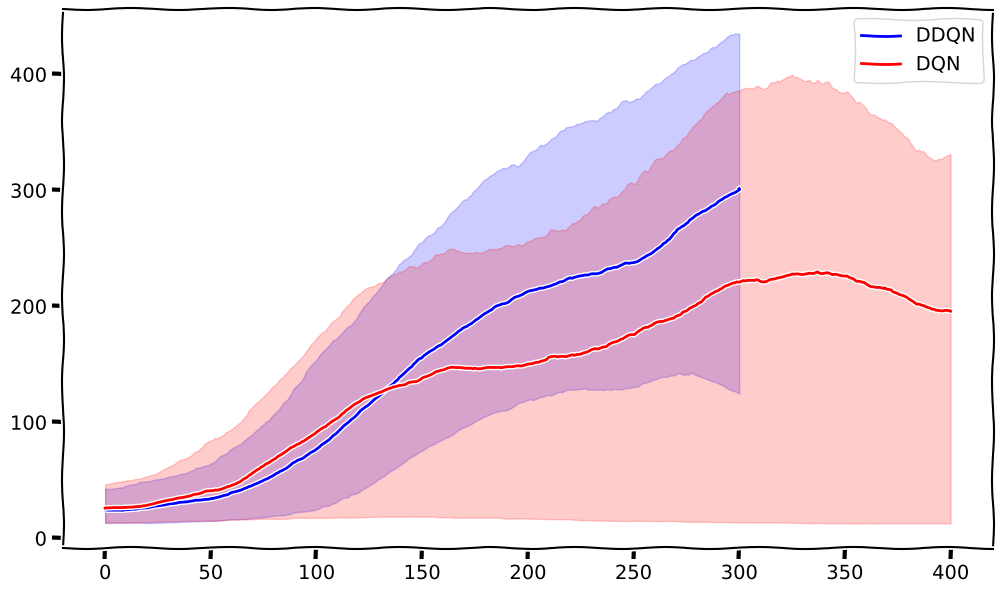

In [23]:
plot_smooth(DDQN_mean_rewards,DDQN_min_rewards,DDQN_max_rewards,DQN_mean_rewards,DQN_min_rewards,DQN_max_rewards)

# Evaluate the Model (10 points)

In order to evaluate the model, we use the following function to measure the average reward and it's standard deviation.

In [17]:
def evaluate_policy(env, agent, num_episodes=3):
    # TODO: Initialize sum of rewards
    total_reward = np.zeros((num_episodes,1))
    Episode_values = []

    for episode in range(num_episodes):

      # TODO: Initialize environment
        state,_ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done,truncated = False,False
        values =[]
        mean_value =[]
      # TODO: In the loop use greedy policy to evaluate your Agent
        while True:

             action,Q = agent.act(state,True)
             next_state,reward,done,truncated,_ = env.step(action)
             total_reward[episode]+=reward
             # appending Q values for later use
             ###################################################
             values.append(Q)
             mean_value.append(np.array(values).mean())
             ###################################################
             if done or truncated:
                break
             next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
             state = next_state

        Episode_values.append(mean_value)

    # TODO: Return mean and std of rewards
    mean = sum(total_reward)/num_episodes
    std = sum((total_reward - mean)**2)/num_episodes


    return mean,std,Episode_values



**Run both Trained Policies for 3 episodes a observe the mean and std of recived Returns also Plot the mean Q values over each episode if the Agent can pass the evaluation bar then we plot their mean values**

evaluating the 0th agent mean_reward = [500.] +/- [0.]

evaluating the 1th agent mean_reward = [35.33333333] +/- [168.22222222]

evaluating the 2th agent mean_reward = [242.33333333] +/- [620.22222222]

evaluating the 3th agent mean_reward = [500.] +/- [0.]

evaluating the 4th agent mean_reward = [466.] +/- [1442.]



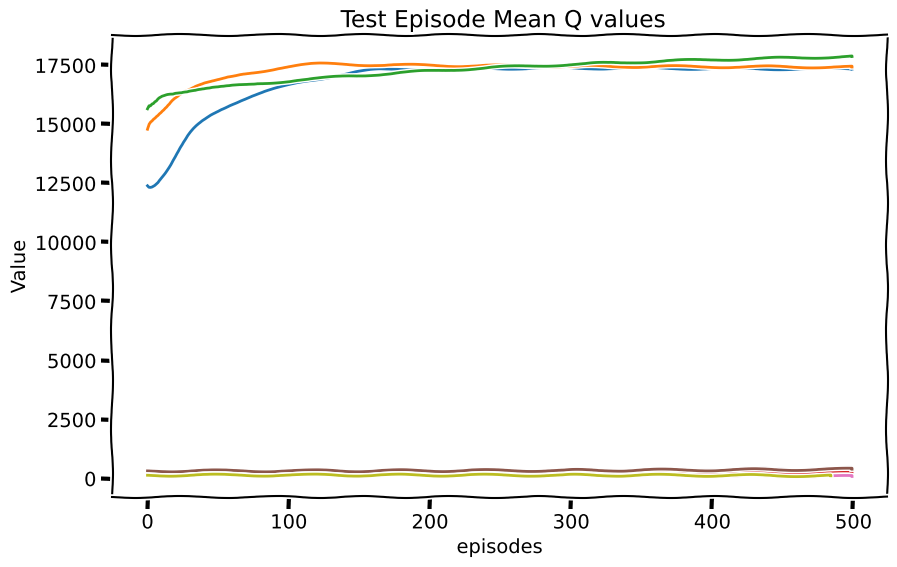

In [26]:
DDQN_values = []
# TODO: Run the each Trained Policy for 3 episodes a observe the mean and std of recived Returns and mean Q values over each episode
for i,DDQN_agent in enumerate(agents):
  # TODO Evaluate the trained Agents
  mean_reward, std_reward,mean_values = evaluate_policy(env, DDQN_agent,num_episodes = 3)
  print(f"evaluating the {i}th agent mean_reward = {mean_reward} +/- {std_reward}\n")
  if mean_reward >= 450:
      DDQN_values.append(mean_values)

if len(DDQN_values) != 0:
  # TODO: Plot the mean values
  plot_values(DDQN_values)
else:
  print('[Info] ... the Agent Did not pass the minimum requirement Please train it more.')

evaluating the 0th agent mean_reward = [500.] +/- [0.]

evaluating the 1th agent mean_reward = [10.] +/- [0.]

evaluating the 2th agent mean_reward = [500.] +/- [0.]

evaluating the 3th agent mean_reward = [153.66666667] +/- [3116.22222222]

evaluating the 4th agent mean_reward = [225.66666667] +/- [2734.88888889]



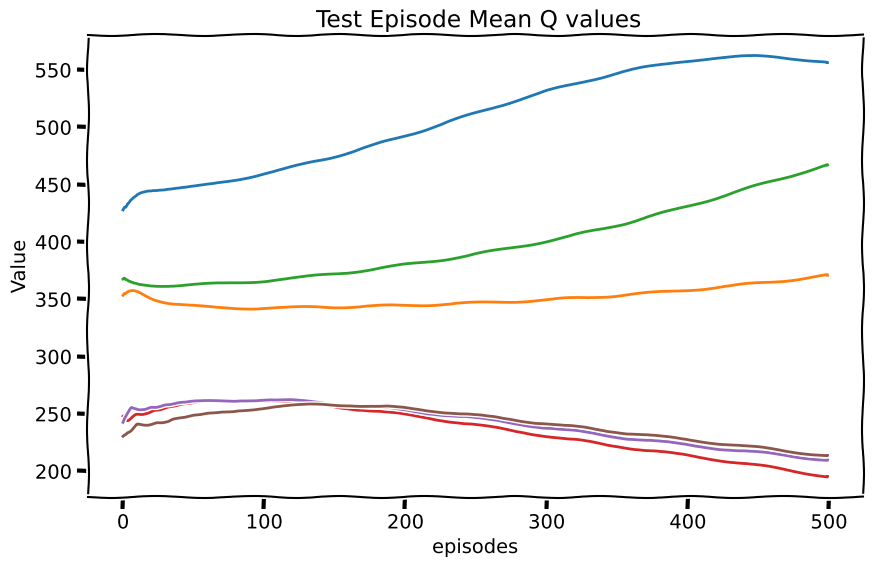

In [25]:
DQN_values = []
# TODO: Run the each Trained Policy for 3 episodes a observe the mean and std of recived Returns and mean Q values over each episode
for i,DQN_agent in enumerate(DQN_agents):
  # TODO Evaluate the trained Agents
  mean_reward, std_reward,mean_values = evaluate_policy(env, DQN_agent,num_episodes = 3)
  print(f"evaluating the {i}th agent mean_reward = {mean_reward} +/- {std_reward}\n")
  if mean_reward >= 450:
      DQN_values.append(mean_values)


if len(DQN_values) != 0:
  # TODO: Plot the mean values
  plot_values(DQN_values)
else:
  print('[Info] ... the Agent Did not pass the minimum requirement Please train it more.')

Watch the best Agent's performance


In [20]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
print('[info] ... rendering the DDQN Agent performance')
# TODO: from the previous evaluation Select the best Agent to render the performance
create_policy_eval_video(env, agents[0], 'greedy_policy', 3)

[info] ... rendering the DDQN Agent performance


In [28]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
print('[info] ... rendering the DQN Agent performance')
# TODO: from the previous evaluation Select the best Agent to render the performance
create_policy_eval_video(env, DQN_agents[0], 'greedy_policy', 3)

[info] ... rendering the DQN Agent performance
